In [ ]:
import os
import pickle
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Preprocessing

In [ ]:
class Loader:
    """Cette classe permet de charger le fichier audio"""

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal


class Padder:
    """Cette classe permet d'appliquer du padding au signal"""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    """Cette classe permet de générer les mel-spectrogrammes"""

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        spectrogram = librosa.feature.melspectrogram(y=signal, sr=22050, n_mels=256,hop_length=self.hop_length)
        return spectrogram


class MinMaxNormaliser:
    """Cette classe permet de normaliser les spectrogrammes"""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


class Saver:
    """Cette classe permet de sauvegarder les spectrogrammes ainsi que les valeurs min-max"""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)
        return save_path

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name[:-4]  + ".npy")
        return save_path


class PreprocessingPipeline:
    """Cette classe reprends toute la pipeline"""

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                print(f"Processed file {file_path}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature = self.normaliser.normalise(feature)
        save_path = self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }

In [ ]:
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 1.485  #Pour avoir 128 échantillons de longueur 
SAMPLE_RATE = 22050
MONO = True

SPECTROGRAMS_SAVE_DIR = "C:/Users/marco/OneDrive/Documents/Code/Projet/spectrograms"
MIN_MAX_VALUES_SAVE_DIR = "C:/Users/marco/OneDrive/Documents/Code/Projet/min_max_values"
FILES_DIR = "C:/Users/marco/OneDrive/Documents/Code/Projet/dataset"

    
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(FILES_DIR)

## Visualisation d'un spectrogramme

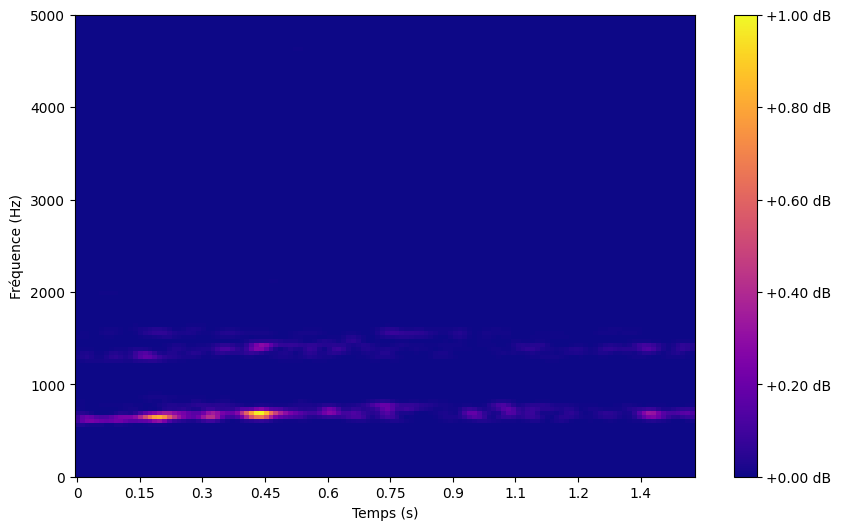

In [1]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

# Charge le spectrogramme depuis le fichier .npy
spectrogram_data = np.load('C:/Users/marco/OneDrive/Documents/Code/Projet/spectrograms/file1252.npy')

# Crée une figure
plt.figure(figsize=(10, 6))

# Affiche le spectrogramme avec librosa.display.specshow
librosa.display.specshow(spectrogram_data, sr=22050, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz', cmap='plasma')

# Limite l'affichage jusqu'à 5000 Hz
plt.ylim(0, 5000)

# Ajouter des labels et un titre
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence (Hz)')

# Afficher la barre de couleur
plt.colorbar(format="%+2.2f dB")

# Afficher la figure
plt.show()


## input shape

In [2]:
spectrogram_data.shape

(256, 128)

## autoencoder variationel (VAE)

In [ ]:

tf.compat.v1.disable_eager_execution()


class VAE:
    """Notre VAE est composé d'un encodeur composé de couches de convolution et d'un décodeur miroir"""

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape
        self.conv_filters = conv_filters 
        self.conv_kernels = conv_kernels 
        self.conv_strides = conv_strides 
        self.latent_space_dim = latent_space_dim
        self.reconstruction_loss_weight = 100000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[self._calculate_reconstruction_loss,
                                    self._calculate_kl_loss])

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss
        return combined_loss

    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
        return reconstruction_loss

    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                               K.exp(self.log_variance), axis=1)
        return kl_loss

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """
        Un bloc de convolution est composé de :
        conv 2d + ReLU + batch norm
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        return x

In [ ]:
VAE(input_shape=(256, 128, 1),conv_filters=(512, 256, 128, 64, 32),conv_kernels=(3, 3, 3, 3, 3),conv_strides=(2, 2, 2, 2, (2, 1)),latent_space_dim=128).summary()

## Model Training

In [ ]:
LEARNING_RATE = 1e-5
BATCH_SIZE = 64
EPOCHS = 100

SPECTROGRAMS_PATH = "C:/Users/marco/OneDrive/Documents/Code/Projet/spectrograms"


def load_fsdd(spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis] # -> (3000, 256, 259, 1)
    return x_train


def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = VAE(
        input_shape=(256, 128, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        latent_space_dim=128
    )
    autoencoder.compile(learning_rate)
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder


In [ ]:
x_train = load_fsdd(SPECTROGRAMS_PATH)
autoencoder = train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)
autoencoder.save("model_PRS_100_epochs")

## Visualisation de l'espace latent

In [ ]:
SPECTROGRAMS_PATH = "C:/Users/marcoOneDrive/Documents/Code/Projet/spectrograms"
HOP_LENGTH = 256
MIN_MAX_VALUES_PATH = "C:/Users/marco/OneDrive/Documents/Code/Projet/min_max_values/min_max_values.pkl"


def load_data(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            data = np.load(file_path)
            spectrogram = data 
            x_train.append(spectrogram)
            file_paths.append(os.path.splitext(file_path)[0])  # Extraction du nom du fichier
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]
    return x_train, file_paths

In [ ]:
vae = VAE.load(save_folder="model_PRS_100_epochs")

    # charge les spectrogrammes et le fichier min-max
with open(MIN_MAX_VALUES_PATH, "rb") as f:
    min_max_values = pickle.load(f)

    
specs, file_paths = load_data(SPECTROGRAMS_PATH)

resized_specs = np.array([np.resize(spec, (256, 128, 1)) for spec in specs])

    # Obtention de l'espace latent
latent_representations = vae.encoder.predict(resized_specs)

    # K-means clustering avec 12 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
cluster_labels = kmeans.fit_predict(latent_representations)

    # Réduction des dimensions de l'espace latent pour visualisation en 2d grâce à l'algo TNSE
tsne = TSNE(n_components=2, random_state=42)
latent_representations_2d = tsne.fit_transform(latent_representations)

    # Plot
plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=cluster_labels, cmap='plasma')
plt.title('Visualisation de l espace latent pour model_PRS_300_epochs avec un KNN 12 clusters')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar()
plt.show()

## Generation de données

In [ ]:
class SoundGenerator:
    """Cette classe permet de générer de l'audio à partir des spectrogrammes avec la méthode Griffin-Lim"""

    def __init__(self, vae, hop_length):
        self.vae = vae
        self.hop_length = hop_length
        self._min_max_normaliser = MinMaxNormaliser(0, 1)

    def generate(self, spectrograms, min_max_values):
        generated_spectrograms, latent_representations = \
            self.vae.reconstruct(spectrograms)
        signals = self.convert_spectrograms_to_audio(generated_spectrograms, min_max_values)
        return signals, latent_representations

    def convert_spectrograms_to_audio(self, spectrograms, min_max_values):
        signals = []
        for spectrogram, min_max_value in zip(spectrograms, min_max_values):
            # reshape the log spectrogram
            log_spectrogram = spectrogram[:, :, 0]
            # apply denormalisation
            denorm_log_spec = self._min_max_normaliser.denormalise(
                log_spectrogram, min_max_value["min"], min_max_value["max"])
            # log spectrogram -> spectrogram
            spec = librosa.db_to_amplitude(denorm_log_spec)
            # apply Griffin-Lim
            signal = librosa.istft(spec, hop_length=self.hop_length)
            # append signal to "signals"
            signals.append(signal)
        return signals

In [ ]:
import os
import pickle

import numpy as np
import soundfile as sf


SAVE_DIR_ORIGINAL = ""
SAVE_DIR_GENERATED = ""



def load_fsdd(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
            file_paths.append(file_path)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis] # -> (3000, 256, 128, 1)
    return x_train, file_paths


def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=2):
    sampled_indexes = np.random.choice(range(len(spectrograms)), num_spectrograms)
    sampled_spectrograms = spectrograms[sampled_indexes]
    file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                           file_paths]
    print(file_paths)
    print(sampled_min_max_values)
    return sampled_spectrograms, sampled_min_max_values


def save_signals(signals, save_dir, sample_rate=44100):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

In [ ]:
    # charge le modèle
vae = VAE.load("model_PRS_300_epochs")
sound_generator = SoundGenerator(vae, HOP_LENGTH)

    # charge les spectrogrammes et les valeurs min-max
with open(MIN_MAX_VALUES_PATH, "rb") as f:
    min_max_values = pickle.load(f)

specs, file_paths = load_fsdd(SPECTROGRAMS_PATH)

    # récupère les spectrogrammes générés
sampled_specs, sampled_min_max_values = select_spectrograms(specs,
                                                            file_paths,
                                                            min_max_values,
                                                            5)

    # génére de l'audio à partir des spectrogrammes générés
signals, _ = sound_generator.generate(sampled_specs,
                                          sampled_min_max_values)

    # génére de l'audio à partir des spectrogrammes originaux
original_signals = sound_generator.convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values)

    # sauvegarde les signaux
save_signals(signals, SAVE_DIR_GENERATED)
save_signals(original_signals, SAVE_DIR_ORIGINAL)

## RETRAIN

In [ ]:
import os
import numpy as np
import pickle

LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 300  # Adjust as needed


def load_fsdd(spectrograms_path, target_shape=(256, 128)):
    x_train = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)  # (n_bins, n_frames, 1)

            x_train.append(spectrogram)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]  # -> (3000, 256, 259, 1)
    return x_train

def load_existing_model(model_path):
    parameters_path = os.path.join(model_path, 'parameters.pkl')
    weights_path = os.path.join(model_path, 'weights.h5')

    with open(parameters_path, 'rb') as f:
        parameters = pickle.load(f)

    input_shape = tuple(parameters[0])
    conv_filters = tuple(parameters[1])
    conv_kernels = tuple(parameters[2])
    conv_strides = tuple(parameters[3])
    latent_space_dim = parameters[4]

    existing_model = VAE(
        input_shape=input_shape,
        conv_filters=conv_filters,
        conv_kernels=conv_kernels,
        conv_strides=conv_strides,
        latent_space_dim=latent_space_dim
    )

    existing_model.load_weights(weights_path)

    return existing_model

def train(existing_model, x_train, learning_rate, batch_size, epochs):
    existing_model.compile(learning_rate)
    existing_model.train(x_train, batch_size, epochs)
    return existing_model


In [ ]:
model_path = " "
model_path2 = " "

x_train = load_fsdd(SPECTROGRAMS_PATH)

if os.path.exists(model_path):
    autoencoder = load_existing_model(model_path)
    print("Loaded existing model.")

    # continue le training
    autoencoder = train(autoencoder, x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)
        
    # sauvegarde le nouveau modèle
    autoencoder.save(os.path.join(model_path2))

    print("Trained and saved new model.")

## Find the index of a wanted spectrogram in the min-max_values file

In [ ]:
def find_index_by_file_path(file_paths, target_file_path):
    try:
        index = file_paths.index(target_file_path)
        return index
    except ValueError:
        print(f"Le fichier {target_file_path} n'a pas été trouvé dans la liste.")
        return None

target_file_path = " "
index = find_index_by_file_path(file_paths, target_file_path)

if index is not None:
    print(f"L'indice du fichier {target_file_path} est : {index}")
else:
    print("Le fichier n'a pas été trouvé.")


## Plot a generated spectrogram from a selected input

In [ ]:
import os
import pickle
import numpy as np
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt


SAVE_DIR_ORIGINAL = ""
SAVE_DIR_GENERATED = ""




def load_data(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)  # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
            file_paths.append(file_path)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]  # -> (3000, 256, 128, 1)
    return x_train, file_paths

def select_spectrogram(spectrograms, file_paths, min_max_values, index):
    selected_spectrogram = spectrograms[index]
    selected_file_path = file_paths[index]
    selected_min_max_values = min_max_values[selected_file_path]
    return selected_spectrogram, selected_min_max_values, selected_file_path

def save_signals(signals, file_paths, save_dir, sample_rate=44100):
    for i, (signal, file_path) in enumerate(zip(signals, file_paths)):
        file_name = os.path.basename(file_path)  # Extract the filename from the path
        save_path = os.path.join(save_dir, file_name.replace(".npy", ".wav"))
        sf.write(save_path, signal, sample_rate)

In [ ]:
    # chargement du modèle
vae = VAE.load("model_PRS_100_epochs")
sound_generator = SoundGenerator(vae, HOP_LENGTH)

    # Chargement des spectrogrammes et des valeurs min_max
with open(MIN_MAX_VALUES_PATH, "rb") as f:
    min_max_values = pickle.load(f)

specs, file_paths = load_data(SPECTROGRAMS_PATH)

    # Choix du spectrogramme avec un indice particulier
selected_index = 221  # Remplacez cela par l'indice du spectrogramme que vous souhaitez utiliser
selected_spec, _, _ = select_spectrogram(specs, file_paths, min_max_values, selected_index)

selected_spec_batched = np.expand_dims(selected_spec, axis=0)

    # Génére un spectrogramme à partir du modèle de VAE
output_spec, _ = sound_generator.generate_specs(selected_spec_batched)

    # Visualise le spectrogramme généré
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(output_spec[0, ..., 0]), aspect='auto', origin='lower', cmap='viridis', extent=[0, selected_spec.shape[1] * HOP_LENGTH / 44100, 0, 21000])
plt.ylim(0, 5000)
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence (Hz)')
plt.title('Spectrogramme G_E1_both Généré par VAE avec 1OO epochs')
plt.colorbar(format="%+2.0f dB")
plt.show()